In [0]:
# Info GPU
from fastai.utils.show_install import *
show_install()
# Info CPU
#!cat /proc/cpuinfo
# Info pamięć
#!cat /proc/meminfo

In [0]:
! pip install git+https://github.com/tensorflow/examples.git
! pip install tensorflow-addons

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
%load_ext tensorboard
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
import numpy as np
from PIL import Image
import os
import datetime
import pathlib

TensorFlow 2.x selected.


In [0]:
os.environ['KAGGLE_USERNAME'] = "" 
os.environ['KAGGLE_KEY'] = ""

In [0]:
! pip uninstall -y kaggle
! pip install --upgrade pip
! pip install kaggle

In [0]:
# Downloading dataset
! kaggle competitions download -c carvana-image-masking-challenge -p /content
! unzip carvana-image-masking-challenge.zip
! unzip test.zip
! unzip train.zip
! unzip train_masks.zip

In [0]:
# Creating TFRecords
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
  
def image_example(image_path, mask_path):

  image = tf.io.read_file(image_path)
  mask = tf.io.read_file(mask_path)

  feature = {
      'height': _int64_feature(1280),
      'width': _int64_feature(1918),
      'image_depth': _int64_feature(3),
      'image': _bytes_feature(image),
      'mask_depth': _int64_feature(1),
      'mask': _bytes_feature(mask),
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

In [0]:
test_files_list = os.listdir("/content/test")
print('Ilość zdjęć testowych: {}'.format(len(test_files_list)))
train_files_list = os.listdir("/content/train")
print('Ilość zdjęć uczących: {}'.format(len(train_files_list)))
train_mask_files_list = os.listdir("/content/train_masks")
print('Ilość zdjęć masek uczących: {}'.format(len(train_mask_files_list)))

# 200 validation examples, 4888 training examples
record_file = 'train.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for index in range(0, len(train_files_list)-200):
    print('Processing image {} of {} / train'.format(index, len(train_files_list)))
    image_path = '/content/train/' + train_files_list[index]
    mask_path = '/content/train_masks/' + train_files_list[index][:-4] + '_mask.gif'
    tf_example = image_example(image_path, mask_path)
    writer.write(tf_example.SerializeToString())

record_file = 'validation.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for index in range(len(train_files_list)-200, len(train_files_list)):
    print('Processing image {} of {} / validation'.format(index, len(train_files_list)))
    image_path = '/content/train/' + train_files_list[index]
    mask_path = '/content/train_masks/' + train_files_list[index][:-4] + '_mask.gif'
    tf_example = image_example(image_path, mask_path)
    writer.write(tf_example.SerializeToString())

In [0]:
# Copying tfrecords from drive
from google.colab import drive
drive.mount('/content/drive')
! cp -a '/content/drive/My Drive/carvana_dataset/'. '/content/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Copying tfrecords to drive
! cp '/content/train.tfrecords' '/content/drive/My Drive/carvana_dataset/'
! cp '/content/validation.tfrecords' '/content/drive/My Drive/carvana_dataset/'

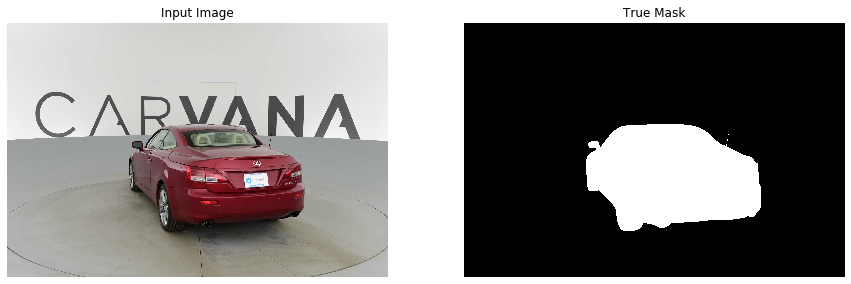

In [0]:
# Read one example from tfrecords

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def display_image_mask(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

raw_image_dataset = tf.data.TFRecordDataset('validation.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'image_depth': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
    'mask_depth': tf.io.FixedLenFeature([], tf.int64),
    'mask': tf.io.FixedLenFeature([], tf.string),
}
parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
for image_features in parsed_image_dataset.take(1):
  image = tf.io.decode_jpeg(image_features['image'], channels=3)
  mask = tf.io.decode_gif(image_features["mask"])
  display_image_mask([image, mask[0]])

In [0]:
# Creating data-pipeline
@tf.function
def random_crop(image, mask):
  zoom = tf.random.uniform(maxval=0.15, shape=[])
  image = tf.image.crop_and_resize(
      image,
      [[zoom,zoom,1.0-zoom,1.0-zoom]],
      [0],
      [1280,1920],
      method='bilinear',
      extrapolation_value=0,
      name=None
  )
  mask = tf.image.crop_and_resize(
      mask,
      [[zoom,zoom,1.0-zoom,1.0-zoom]],
      [0],
      [1280,1920],
      method='bilinear',
      extrapolation_value=0,
      name=None
  )
  return image, mask

@tf.function
def random_rotate(image, mask):
  angle = tf.random.uniform(maxval=0.05, shape=[])
  image = tfa.image.rotate(
      image,
      angle,
      interpolation='bilinear',
      name=None
  )
  mask = tfa.image.rotate(
      mask,
      angle,
      interpolation='bilinear',
      name=None
  )

  return image, mask

@tf.function
def resize(image):
  return tf.image.resize(
    image,
    [1280,1920],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=False,
    name=None
  )

@tf.function
def preprocessing(image, mask):
  # [1280, 1918, 3] > [1, 1280, 1918, 3] 3D>4D
  image = tf.expand_dims(image, 0)
  # [1, 1280, 1918, 3] > [1, 1280, 1918, 1] reducing 3 channels to one
  mask = tf.expand_dims(mask[:,:,:,0], 3)
  # Normalize
  image = tf.cast(image, tf.float32) / 255.0
  mask = tf.cast(mask, tf.float32) / 255.0
  if tf.random.uniform(()) > 0.5:
    image, mask = random_rotate(image, mask)
  if tf.random.uniform(()) > 0.25:
    image, mask = random_crop(image, mask)
  image = resize(image)
  mask = resize(mask)
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  
  # [1, 1280, 1918, 3] > [1280, 1918, 3] 4D>3D
  image = tf.squeeze(image, 0)
  # [1, 1280, 1918, 3] > [1280, 1918, 1] 4D>3D
  mask = tf.squeeze(mask, 0)
  return image, mask

@tf.function
def parse_fn(example):
  "Parse TFExample records and perform simple data augmentation."
  image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'image_depth': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
    'mask_depth': tf.io.FixedLenFeature([], tf.int64),
    'mask': tf.io.FixedLenFeature([], tf.string),
  }
  parsed = tf.io.parse_single_example(example, image_feature_description)
  image = tf.io.decode_jpeg(parsed["image"])  
  mask = tf.io.decode_gif(parsed["mask"])     
  image, mask = preprocessing(image, mask)
  return image, mask

def make_dataset(path, batch_size):
  files = tf.data.Dataset.list_files(path)
  dataset = tf.data.TFRecordDataset(files)
  dataset = dataset.shuffle(buffer_size=100)
  dataset = dataset.map(map_func=parse_fn, num_parallel_calls=2)
  dataset = dataset.batch(batch_size=batch_size).repeat()
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

BATCH_SIZE = 3
training_dataset = make_dataset("/content/train.tfrecords", batch_size=BATCH_SIZE)
validation_dataset = make_dataset("/content/validation.tfrecords", batch_size=BATCH_SIZE)

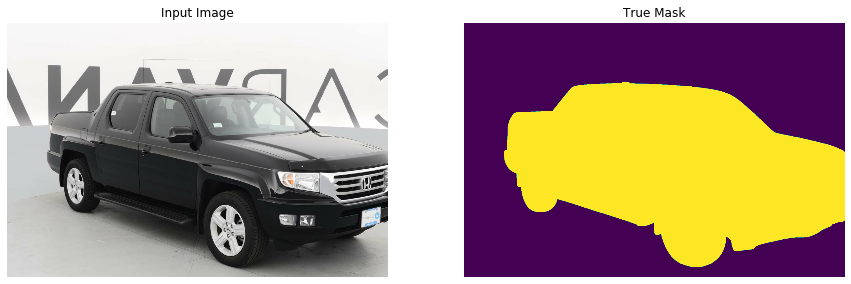

In [0]:
# Example from data-pipeline
example = next(iter(validation_dataset))
display_image_mask([example[0][0], example[1][0]])

In [0]:
# Feature extractor
base_model = tf.keras.applications.MobileNetV2(input_shape=[1280, 1920, 3], include_top=False)

# Output layers names
layer_names = [
    'block_1_expand_relu', # None, 640, 960, 96 -> level 2
    'block_3_expand_relu', # None, 320, 480, 144 -> level 3
    'block_6_expand_relu', # None, 160, 240, 192 -> level 4
    'block_13_expand_relu',# None, 80, 120, 576 -> level 5
    'block_16_project',    # None, 40, 60, 320 -> level 6
]

# Outputs
bottom_up_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
bottom_up_model = tf.keras.Model(inputs=base_model.input, outputs=bottom_up_outputs)
bottom_up_model.trainable = True

In [0]:
base_model.summary()

In [0]:
tf.keras.utils.plot_model(bottom_up_model, show_shapes=True)

In [0]:
bottom_up_input = tf.keras.layers.Input(shape=[1280, 1920, 3]) 
bottom_up_tensors = bottom_up_model(bottom_up_input)

def upsample(filters, size):
  """https://www.tensorflow.org/tutorials/generative/pix2pix"""
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())
  return result

# Top-down
level6 = bottom_up_tensors[-1]
level6 = upsample(512, (3,3))(level6)

level5 = tf.keras.layers.concatenate([level6, bottom_up_tensors[-2]])
level5 = upsample(256, (3,3))(level5)

level4 = tf.keras.layers.concatenate([level5, bottom_up_tensors[-3]])
level4 = upsample(128, (3,3))(level4)

level3 = tf.keras.layers.concatenate([level4, bottom_up_tensors[-4]])
level3 = upsample(64, (3,3))(level3)

level2 = tf.keras.layers.concatenate([level3, bottom_up_tensors[-5]])
layer = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3,3), strides=2, padding='same', activation='sigmoid')
top_down_output = layer(level2)

model = tf.keras.Model(inputs=bottom_up_input, outputs=top_down_output, name='MobileNetV2_FPN')

In [0]:
model.summary()

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.0001
  #if epoch >= 1:
  #  learning_rate = 0.0001
  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Automatic lr reduction
reduce_learning_rate_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Print lr during training
class print_lr_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print ('\nLearning rate: {}\n'.format(tf.keras.backend.eval(self.model.optimizer.lr)))

# Plot one prediction at the end of epoch
for image, mask in validation_dataset.take(1):
  image_example = image[0]
  mask_example = mask[0]
class display_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    display_image_mask([image_example, mask_example, model.predict(np.expand_dims(image_example,0))[0]])

# Logs
log_dir = "training/logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training/ckpt/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

In [0]:
# Load weights
latest = tf.train.latest_checkpoint('/content/weights/')
model.load_weights(latest, by_name=True)

In [0]:
! rm -r '/content/training'

In [0]:
%tensorboard --logdir '/content/training/logs' --port 6008

Train for 162.93333333333334 steps, validate for 66.66666666666667 steps
Epoch 1/100
162/162 [============================>.] - ETA: 1s - loss: 0.0069 - accuracy: 0.9957
Epoch 00001: saving model to training/ckpt/cp-0001.ckpt

Sample Prediction after epoch 1



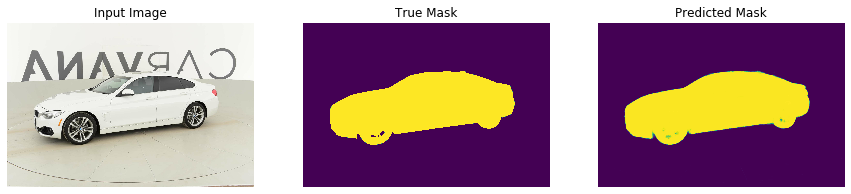


Learning rate: 9.999999747378752e-05

163/162 [==============================] - 222s 1s/step - loss: 0.0069 - accuracy: 0.9957 - val_loss: 0.0064 - val_accuracy: 0.9958
Epoch 2/100
162/162 [============================>.] - ETA: 1s - loss: 0.0057 - accuracy: 0.9959
Epoch 00002: saving model to training/ckpt/cp-0002.ckpt

Sample Prediction after epoch 2



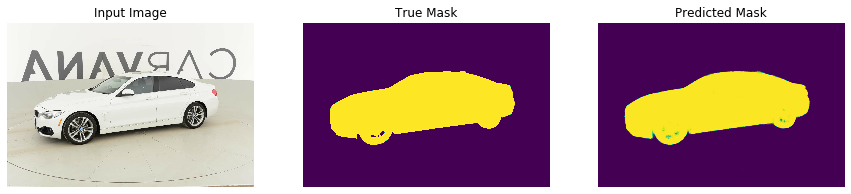


Learning rate: 9.999999747378752e-05

163/162 [==============================] - 222s 1s/step - loss: 0.0057 - accuracy: 0.9959 - val_loss: 0.0064 - val_accuracy: 0.9956
Epoch 3/100
162/162 [============================>.] - ETA: 1s - loss: 0.0053 - accuracy: 0.9960
Epoch 00003: saving model to training/ckpt/cp-0003.ckpt

Sample Prediction after epoch 3



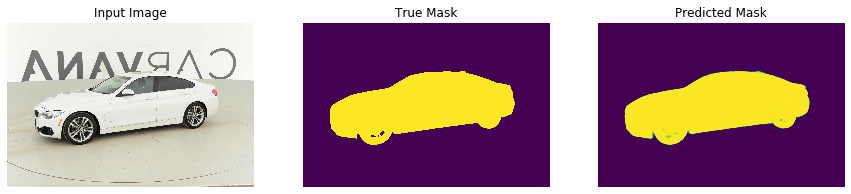


Learning rate: 9.999999747378752e-05

163/162 [==============================] - 222s 1s/step - loss: 0.0053 - accuracy: 0.9960 - val_loss: 0.0060 - val_accuracy: 0.9957
Epoch 4/100
162/162 [============================>.] - ETA: 1s - loss: 0.0055 - accuracy: 0.9959
Epoch 00004: saving model to training/ckpt/cp-0004.ckpt

Sample Prediction after epoch 4



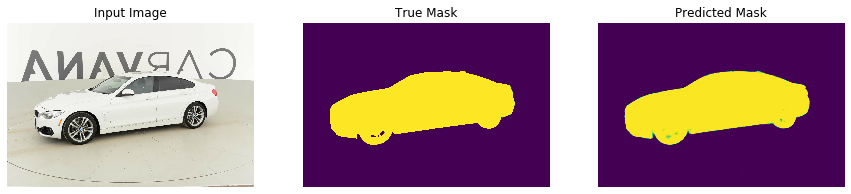


Learning rate: 9.999999747378752e-05

163/162 [==============================] - 220s 1s/step - loss: 0.0055 - accuracy: 0.9959 - val_loss: 0.0059 - val_accuracy: 0.9959
Epoch 5/100
162/162 [============================>.] - ETA: 1s - loss: 0.0056 - accuracy: 0.9960
Epoch 00005: saving model to training/ckpt/cp-0005.ckpt

Sample Prediction after epoch 5



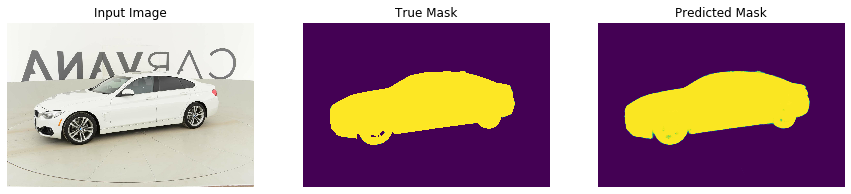


Learning rate: 9.999999747378752e-05

163/162 [==============================] - 221s 1s/step - loss: 0.0056 - accuracy: 0.9960 - val_loss: 0.0060 - val_accuracy: 0.9957
Epoch 6/100
162/162 [============================>.] - ETA: 1s - loss: 0.0053 - accuracy: 0.9960
Epoch 00006: saving model to training/ckpt/cp-0006.ckpt

Sample Prediction after epoch 6



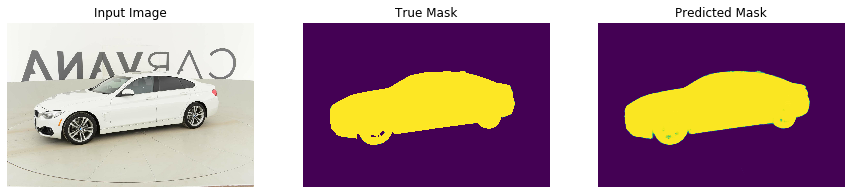


Learning rate: 9.999999747378752e-05

163/162 [==============================] - 220s 1s/step - loss: 0.0053 - accuracy: 0.9960 - val_loss: 0.0058 - val_accuracy: 0.9958
Epoch 7/100
162/162 [============================>.] - ETA: 1s - loss: 0.0053 - accuracy: 0.9959
Epoch 00007: saving model to training/ckpt/cp-0007.ckpt

Sample Prediction after epoch 7



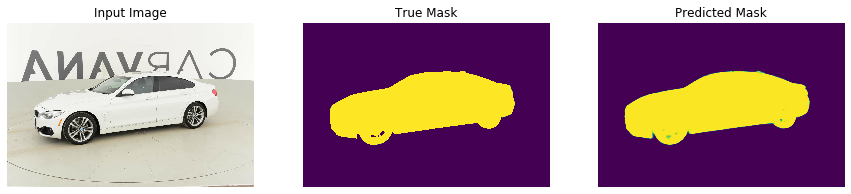


Learning rate: 9.999999747378752e-05

163/162 [==============================] - 220s 1s/step - loss: 0.0053 - accuracy: 0.9959 - val_loss: 0.0059 - val_accuracy: 0.9958
Epoch 8/100
 41/162 [======>.......................] - ETA: 2:24 - loss: 0.0050 - accuracy: 0.9962
Epoch 00008: saving model to training/ckpt/cp-0008.ckpt

Sample Prediction after epoch 8



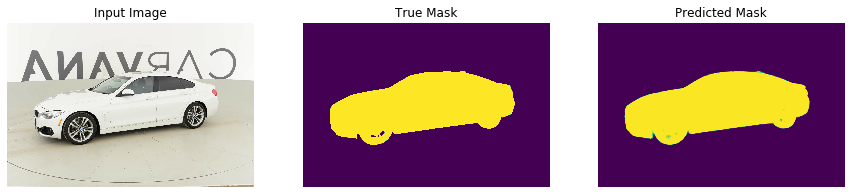


Learning rate: 9.999999747378752e-05

 41/162 [======>.......................] - ETA: 2:31 - loss: 0.0050 - accuracy: 0.9962

KeyboardInterrupt: ignored

In [0]:
# Training
history = model.fit(training_dataset, 
                    epochs=100, # prawdziwy epoch = epoch/10
                    steps_per_epoch=4888/10/BATCH_SIZE,
                    validation_data=validation_dataset, 
                    validation_steps=200/BATCH_SIZE,
                    validation_freq=1, 
                    callbacks=[tensorboard_callback, 
                               learning_rate_callback, 
                               checkpoint_callback, 
                               display_callback(),
                               reduce_learning_rate_callback,
                               print_lr_callback()])

In [0]:
import skimage
example = plt.imread('/content/example.png')
example = skimage.transform.resize(example, [1280, 1920])
example = np.expand_dims(example[:,:,0:3], 0)
prediction = model.predict(example)[0]
plt.imsave('/content/example_prediction.png', np.concatenate([prediction,prediction,prediction], 2))
display_image_mask([example[0], prediction])